In [1]:
import numpy as np
import scipy.stats as stats
import pylab as plt 
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV

import corner
plt.rcParams['figure.figsize'] = [8,5]
%config InlineBackend.figure_format='retina'

In [2]:
from sklearn.neighbors import KernelDensity
from astropy.visualization.hist import hist as fancyhist

def kde_sklearn(data, bandwidth = 1.00, kernel="linear"):
    kde_skl = KernelDensity(bandwidth = bandwidth, 
                            kernel=kernel)
    kde_skl.fit(data[:, np.newaxis])
    xgrid = np.linspace(np.min(data), np.max(data), 1000)
    log_pdf = kde_skl.score_samples(xgrid[:, np.newaxis])

    return np.exp(log_pdf)

In [3]:
import requests

# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

## Data: time and fluence

First of all I remove the non physical data for time and fluence. In order to implement the errors I do a resampling of each point from a gaussian centered at that point and with width equal to the error.

In [4]:
np.random.seed(42)

In [5]:
T90=np.array(data[6],dtype=float)
fluence=np.array(data[9],dtype=float)
mask = np.logical_and(T90>0, fluence>0)
T90 = T90[mask]
fluence = fluence[mask]
T90_err=np.array(data[7],dtype=float)[mask]
fluence_err=np.array(data[10],dtype=float)[mask]

mask2 = T90_err>0
mask3 = fluence_err>0

T90[mask2] = np.random.normal(T90[mask2], T90_err[mask2])
fluence[mask3] = np.random.normal(fluence[mask3], fluence_err[mask3])
mask4 = np.logical_and(T90>0, fluence>0)

T_f = np.log10(np.column_stack((T90[mask4], fluence[mask4])))
T = T_f[:,0][:,np.newaxis]
f = T_f[:,1][:,np.newaxis]

print('Data of time and fluence:', np.shape(T_f))

Data of time and fluence: (7069, 2)


## Time

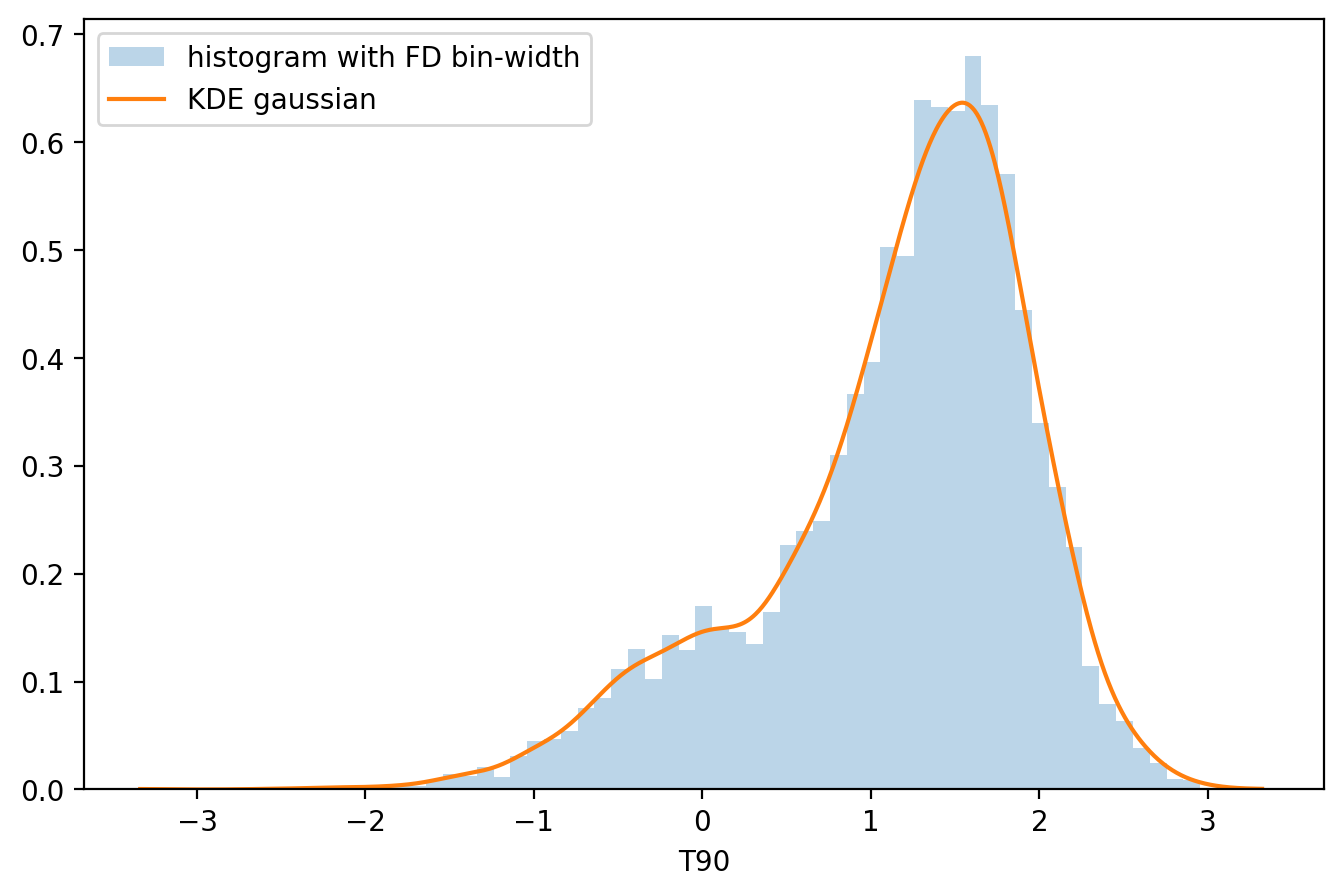

In [6]:
_ = fancyhist(T, bins='freedman', alpha=0.3, density=True, label='histogram with FD bin-width') 
bwrange = np.linspace(0.01,0.3, 20)
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv=10)
grid.fit(T)
bw_opt = grid.best_params_['bandwidth']
PDFgauss = kde_sklearn(T.squeeze(), bandwidth=bw_opt, kernel='gaussian')
Tgrid = np.linspace(np.min(T), np.max(T), 1000)
plt.plot(Tgrid, PDFgauss, label='KDE gaussian')
plt.xlabel('T90')
plt.legend()
plt.show()

### Clustering
This distribution suggests that there may be two clusters. I try both K-means and Mean Shift to see if they return the same results. I also use Mean-shift to check if the number of clusters estimate is 2.

K-means: 

Centers:  [1.53799574 0.02309514]
Boundary:  0.7823944878686264  (6.059 seconds)


Mean-shift : 

Number of estimated clusters : 2
Centers:  [ 1.52140852 -3.33732134]
Boundary:  -0.904155843199403  (0.125 seconds)


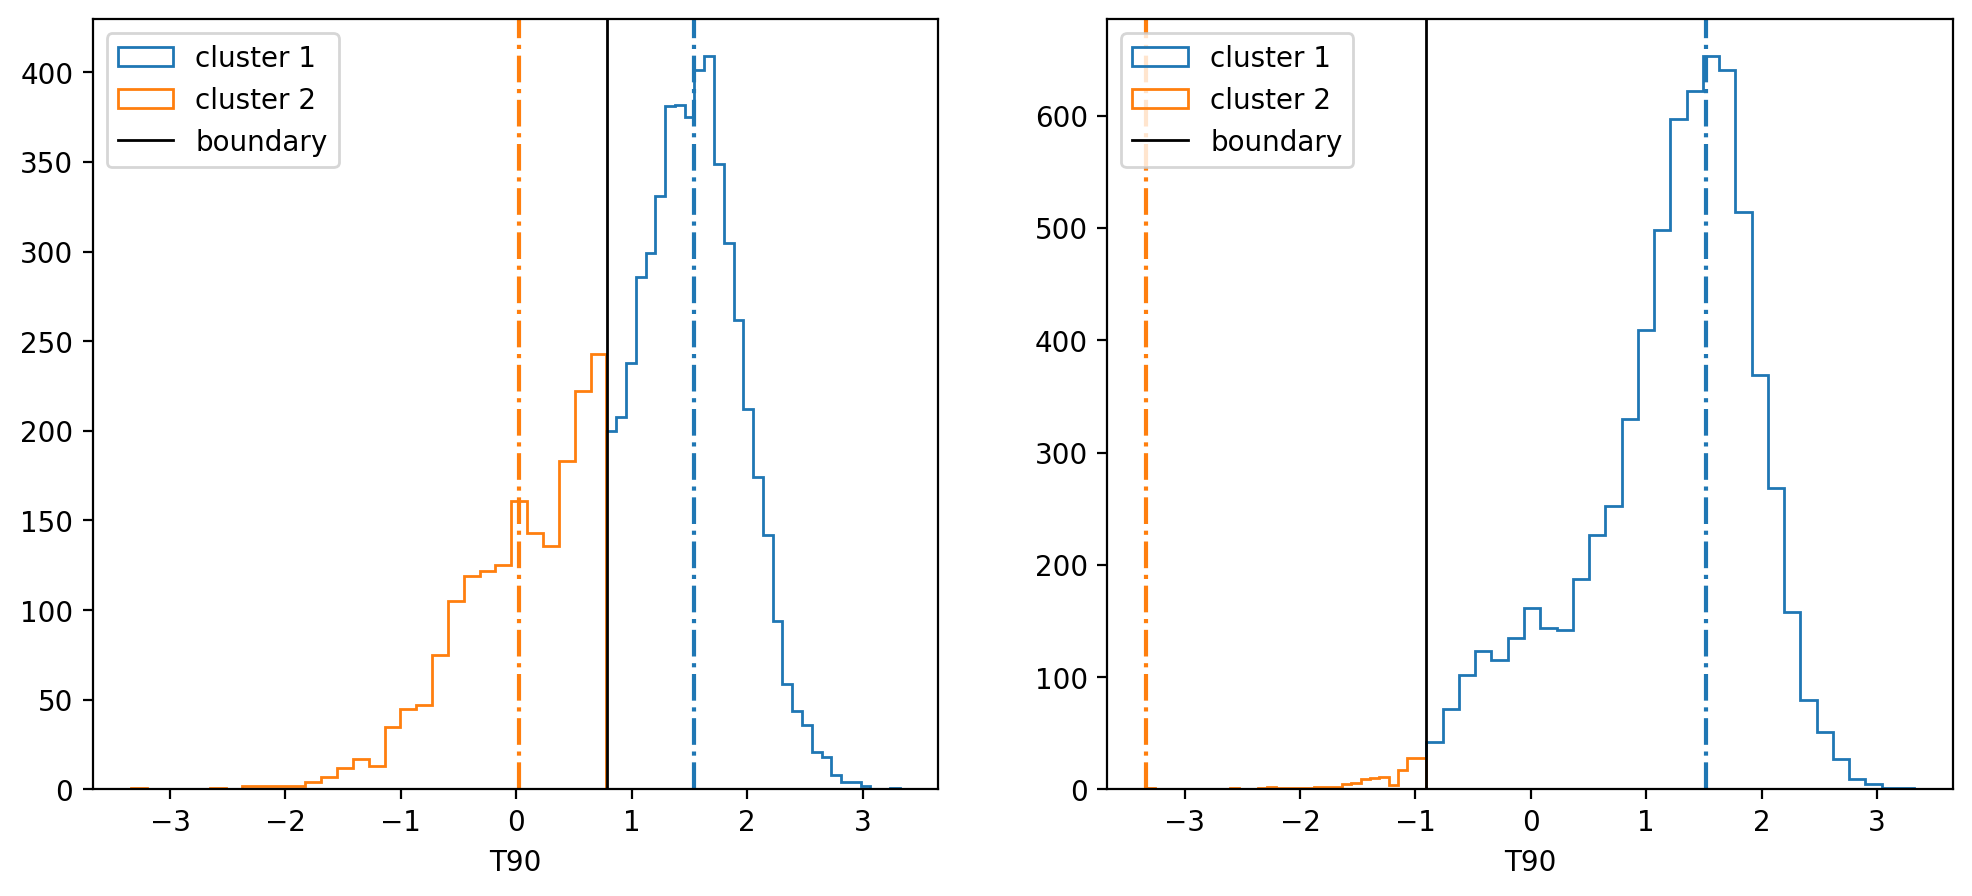

In [7]:
fig, ax = plt.subplots(1,2,figsize=(12, 5))
colors=['C0','C1']

n_clusters = 2
scaler = preprocessing.StandardScaler()
clf = KMeans(n_clusters, n_init=10)
clf.fit(scaler.fit_transform(T))
cluster_centers = scaler.inverse_transform(clf.cluster_centers_)
labels = clf.predict(scaler.fit_transform(T))
if cluster_centers[0]<cluster_centers[1]:
    cluster_centers = cluster_centers[::-1]
    labels = np.array(~np.array(labels,dtype='bool'),dtype='int')
    
print('K-means: \n')
print('Centers: ', cluster_centers.flatten())

for i,c in zip(range(n_clusters),colors):
    ax[0].hist(T[labels==i], bins=30, histtype='step', color=c, label='cluster %i'%(i+1))
    ax[0].axvline(cluster_centers[i], color=c, ls='dashdot')
    
# plot cluster boundary
Xgrid = np.linspace(np.min(T), np.max(T), 1000)[:,np.newaxis]
pred = clf.predict(scaler.transform(Xgrid))[:,np.newaxis]
l, counts = np.unique(pred, return_counts=True)
boundary = Xgrid[counts[l==pred[0]]].item()
print('Boundary: ', boundary, ' (%.3f seconds)' %10**boundary)

ax[0].axvline(boundary, color='black', lw= 1, label='boundary')
ax[0].set_xlabel('T90')
ax[0].legend()

print('\n')

scaler = preprocessing.StandardScaler()
bandwidth = estimate_bandwidth(scaler.fit_transform(T), quantile=0.2)
ms1 = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=True)
ms1.fit(scaler.fit_transform(T))
labels = ms1.labels_
labels_unique = np.unique(ms1.labels_)
n_clusters = len(labels_unique[labels_unique >= 0])
cluster_centers = scaler.inverse_transform(ms1.cluster_centers_)
if cluster_centers[0]<cluster_centers[1]:
    cluster_centers = cluster_centers[::-1]
    labels = np.array(~np.array(labels,dtype='bool'),dtype='int')
print('Mean-shift : \n')
print("Number of estimated clusters :", n_clusters)
print('Centers: ', cluster_centers.flatten())

for i,c in zip(range(n_clusters),colors):
    ax[1].hist(T[labels==i], bins=30, histtype='step', color=c, label='cluster %i'%(i+1))
    ax[1].axvline(cluster_centers[i], color=c, ls='dashdot')
    
# plot cluster boundary
Xgrid = np.linspace(np.min(T), np.max(T), 1000)[:,np.newaxis]
pred = ms1.predict(scaler.transform(Xgrid))[:,np.newaxis]
l, counts = np.unique(pred, return_counts=True)
boundary = (Xgrid[counts[l==pred[0]]]).item()
print('Boundary: ', boundary, ' (%.3f seconds)' %10**boundary)
ax[1].axvline(boundary, color='black', lw= 1, label='boundary')
ax[1].set_xlabel('T90')
ax[1].legend()
plt.show()

The two methods behave in a different way: the clustering of K-means is more reliable, while Mean-shift seems to give too much weight to the distant points of the low-T distribution, shifting the center of the cluster towards them. Even with 'cluster_all=False' the centers are the same.

### Gaussian Mixture
Now I fit a Gaussian Mixture model. Firstly, I check that the best number of components is 2, as expected.

Gaussian Mixture : 

The best number of components is : 2
Means:  [1.50383018 0.10116703]


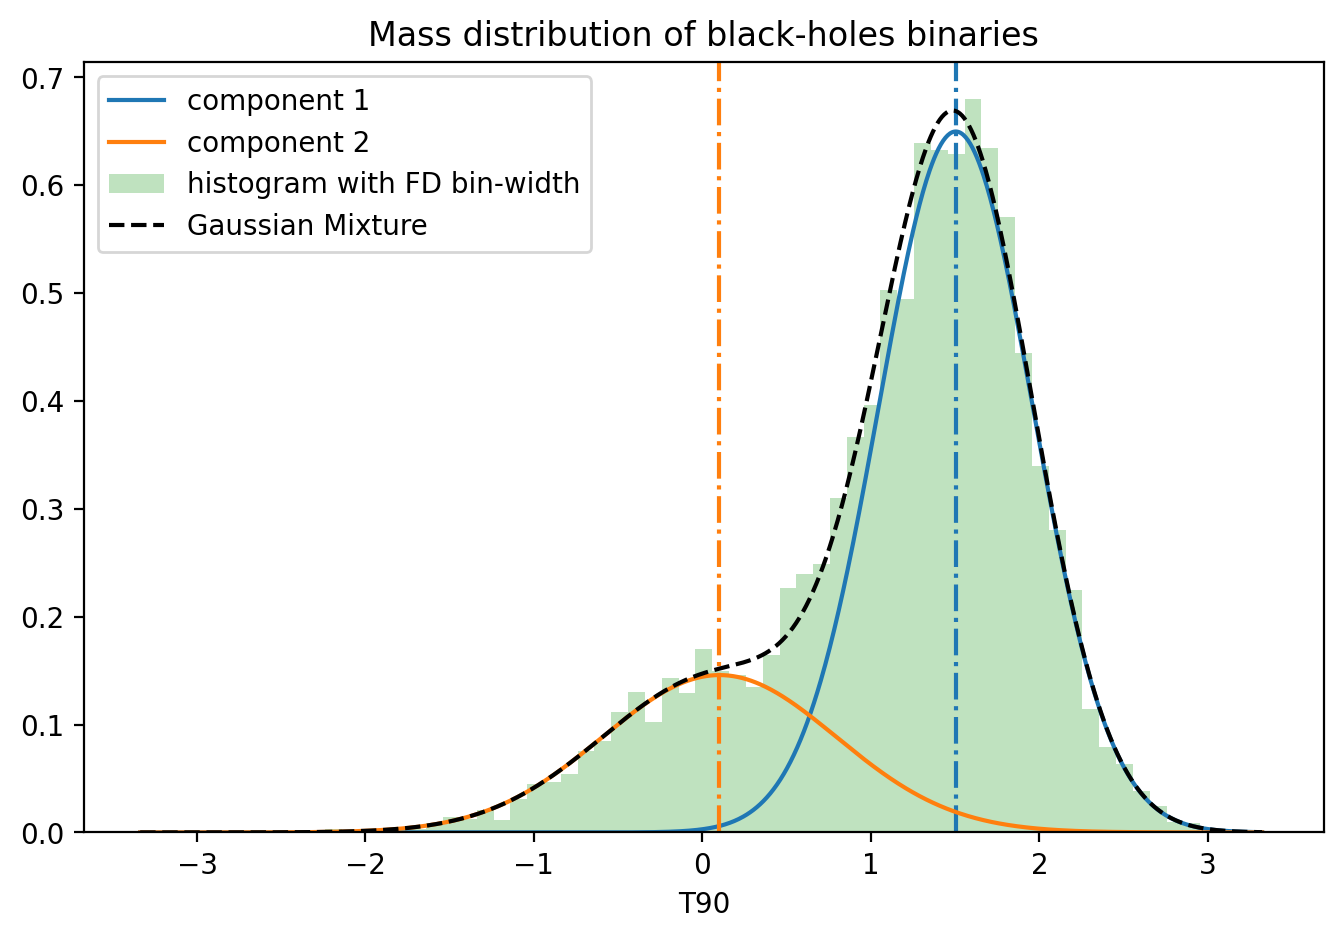

In [8]:
from sklearn.mixture import GaussianMixture
N = np.arange(1,5)
gmm = [GaussianMixture(n, random_state=0).fit(T) for n in N]
aic = [model.aic(T) for model in gmm]
best_N = N[np.argmin(aic)]
print('Gaussian Mixture : \n')
print('The best number of components is :', best_N)

best_gmm = GaussianMixture(best_N, random_state=0).fit(T)
x = np.linspace(np.min(T), np.max(T),1000)
logprob = best_gmm.score_samples(x.reshape(-1,1))
pdf = np.exp(logprob)
densities = best_gmm.predict_proba(x.reshape(-1,1))
sing_pdf = densities*pdf.reshape(-1,1)
means = best_gmm.means_.squeeze()

if means[0] < means[1]:
    means = means[::-1]
    sing_pdf = sing_pdf[:,::-1]
print('Means: ', means)

for i,c in zip(range(best_N),colors):
    plt.plot(x, sing_pdf[:,i], color=c, linestyle='-', label='component %i' %(i+1))
    plt.axvline(means[i], color=c, ls='dashdot')

_ = fancyhist(T, bins='freedman', color='C2', alpha=0.3, density=True, label='histogram with FD bin-width')
plt.plot(x, pdf, label='Gaussian Mixture', color='black',linestyle='--')
plt.title('Mass distribution of black-holes binaries')
plt.xlabel('T90')
plt.legend()
plt.show()

The two components resemble the two clusters resulted with K-means: the means of the gaussians are similar to the cluster centers found before.

## Fluence

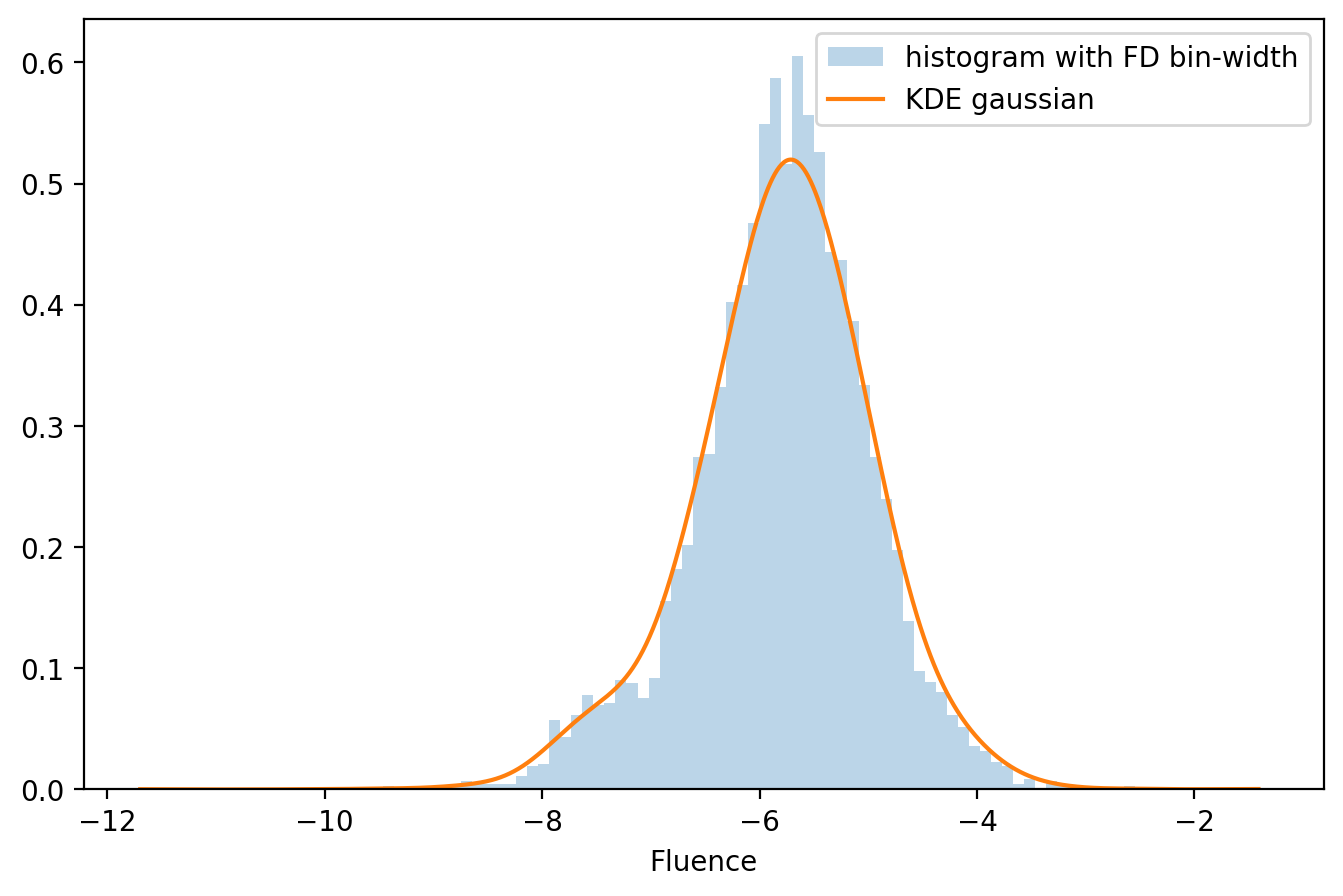

In [9]:
_ = fancyhist(f, bins='freedman', alpha=0.3, density=True, label='histogram with FD bin-width')
bwrange = np.linspace(0.01,0.3, 20)
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv=10)
grid.fit(f)
bw_opt = grid.best_params_['bandwidth']
PDFgauss = kde_sklearn(f.squeeze(), bandwidth=bw_opt, kernel='gaussian')
fgrid = np.linspace(np.min(f), np.max(f), 1000)
plt.plot(fgrid, PDFgauss, label='KDE gaussian')
plt.xlabel('Fluence')

plt.legend()
plt.show()

I try K-means to find two clusters as I did with T90, even if they are way less evident, so I don't expect a clear boundary

### Clustering

KMeans:
Centers:  [-5.28455751 -6.55495153]
Boundary:  -5.910410774990878


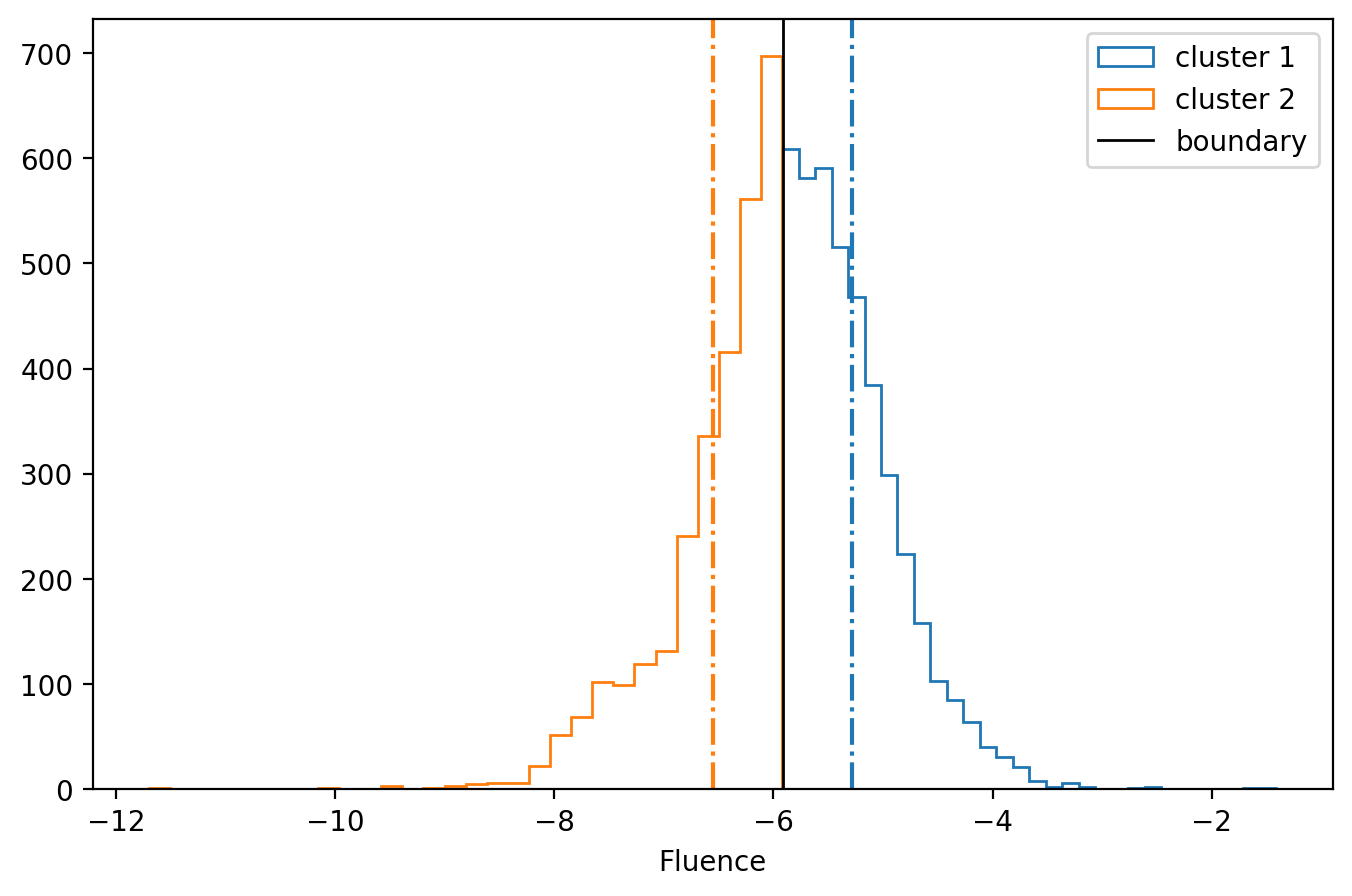

In [10]:
n_clusters = 2
scaler = preprocessing.StandardScaler()
clf = KMeans(n_clusters, n_init=10)
clf.fit(scaler.fit_transform(f))
cluster_centers = scaler.inverse_transform(clf.cluster_centers_)
labels = clf.predict(scaler.fit_transform(f))
if cluster_centers[0]<cluster_centers[1]:
    cluster_centers = cluster_centers[::-1]
    labels = np.array(~np.array(labels,dtype='bool'),dtype='int')
    
print('KMeans:')
print('Centers: ', cluster_centers.flatten())

# Make some plots
colors=['C0','C1']

for i,c in zip(range(n_clusters),colors):
    plt.hist(f[labels==i], bins=30, histtype='step', color=c, label='cluster %i'%(i+1))
    plt.axvline(cluster_centers[i], color=c, ls='dashdot')
    
# plot cluster boundary
Xgrid = np.linspace(np.min(f), np.max(f), 1000)[:,np.newaxis]
pred = clf.predict(scaler.transform(Xgrid))[:,np.newaxis]
l, counts = np.unique(pred, return_counts=True)
boundary = Xgrid[counts[l==pred[0]]].item()

plt.axvline(boundary, color='black', lw= 1, label='boundary')
plt.xlabel('Fluence')
plt.legend()

print('Boundary: ', boundary)

## Time and Fluence
Now I finally analyze together the data of time and fluence. Since I expect two populations I use K-means with n_clusters=2 and I also try again with Mean-shift

KMeans: 

Centers: 
 [[ 1.53501952 -5.45262811]
 [ 0.11584114 -6.70905068]]


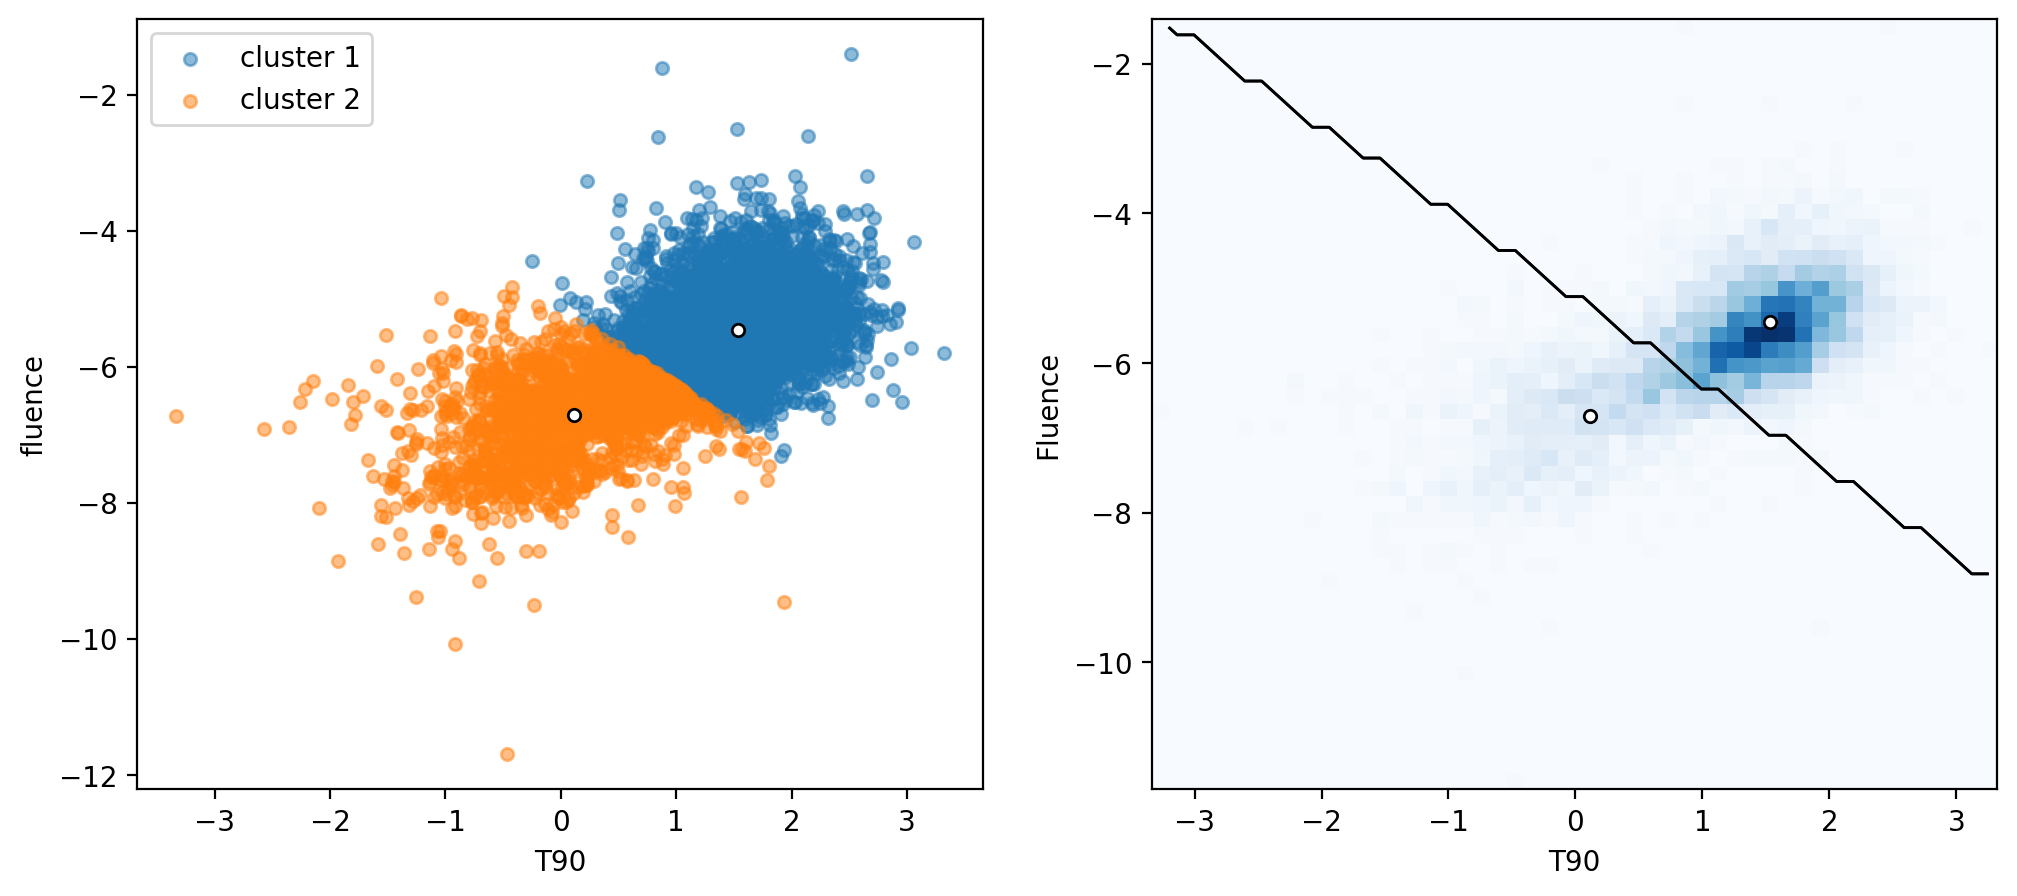

In [11]:
n_clusters = 2
scaler = preprocessing.StandardScaler()
clf = KMeans(n_clusters, n_init=10)
clf.fit(scaler.fit_transform(T_f))
cluster_centers = scaler.inverse_transform(clf.cluster_centers_)
labels = clf.predict(scaler.fit_transform(T_f))
if cluster_centers[0,0]<cluster_centers[1,0]:
    cluster_centers = cluster_centers[::-1]
    labels = np.array(~np.array(labels,dtype='bool'),dtype='int')
    
print('KMeans: \n')
print('Centers: \n', cluster_centers)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].set_xlabel('T90')
ax[0].set_ylabel('fluence')
for i,c in zip(range(n_clusters),colors):
    ax[0].scatter(T_f[labels==i,0], T_f[labels==i,1], s=20, color=c, alpha=0.5, label='cluster %i'%(i+1))
    ax[0].scatter(cluster_centers[i,0], cluster_centers[i,1], color='w',edgecolors='k', s=20)
ax[0].legend()
H, xedges, yedges = np.histogram2d(T_f[:,0], T_f[:,1], 50)

ax[1].imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],
                  yedges[0], yedges[-1]],
          cmap='Blues')

ax[1].scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=20, c='w', edgecolors='k')

x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T


H = clf.predict(scaler.transform(Xgrid)).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax[1].contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')

    H = clf.predict(scaler.transform(Xgrid)).reshape((50, 50))
    
ax[1].set_xlim(xedges[0], xedges[-1])
ax[1].set_ylim(yedges[0], yedges[-1])

ax[1].set_xlabel('T90')
ax[1].set_ylabel('Fluence')

plt.show()

Mean-shift: 

Number of estimated clusters : 5
Centers: 
 [[  1.46816091  -5.60780228]
 [  1.08259742  -2.2437673 ]
 [  2.51181384  -1.4103392 ]
 [  1.93808917  -9.4566177 ]
 [ -0.46298198 -11.69768818]]


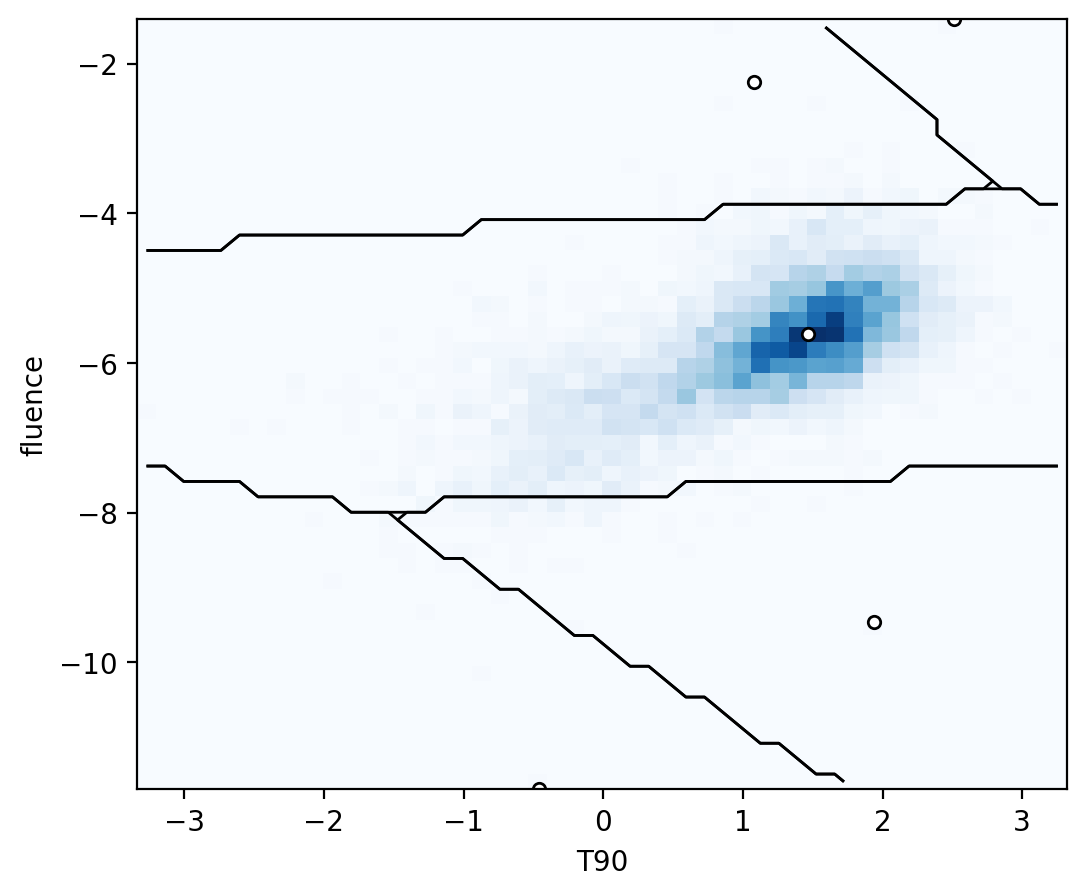

In [12]:
scaler = preprocessing.StandardScaler()
bandwidth = estimate_bandwidth(scaler.fit_transform(T_f), quantile=0.3)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=False)
ms.fit(scaler.fit_transform(T_f))

labels_unique = np.unique(ms.labels_)

n_clusters = len(labels_unique[labels_unique >= 0])
print('Mean-shift: \n')
print("Number of estimated clusters :", n_clusters)

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot()

H, xedges, yedges = np.histogram2d(T_f[:,0], T_f[:,1], 50)

ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],
                  yedges[0], yedges[-1]],
          cmap='Blues')

cluster_centers = scaler.inverse_transform(ms.cluster_centers_)
print('Centers: \n', cluster_centers)

ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=20, c='w', edgecolors='k')

x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = ms.predict(scaler.transform(Xgrid)).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')
 
    H = ms.predict(scaler.transform(Xgrid)).reshape((50, 50))
    
ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])

ax.set_xlabel('T90')
ax.set_ylabel('fluence')

plt.show()

K-means works really well and the coordinate of the clusters are the nearly the same found before using only time or fluence. On the other hand, Mean-shift still gives too much weight to outliers (maybe because it uses a quadratic function) so it fails in estimating the fainter population.

### Gaussian Mixture
As I did before I fit a Gaussian Mixture model with 2 components.

Gaussian Mixture : 

Means : 
 [[ 1.50503959 -5.52068288]
 [ 0.12328444 -6.58342877]]


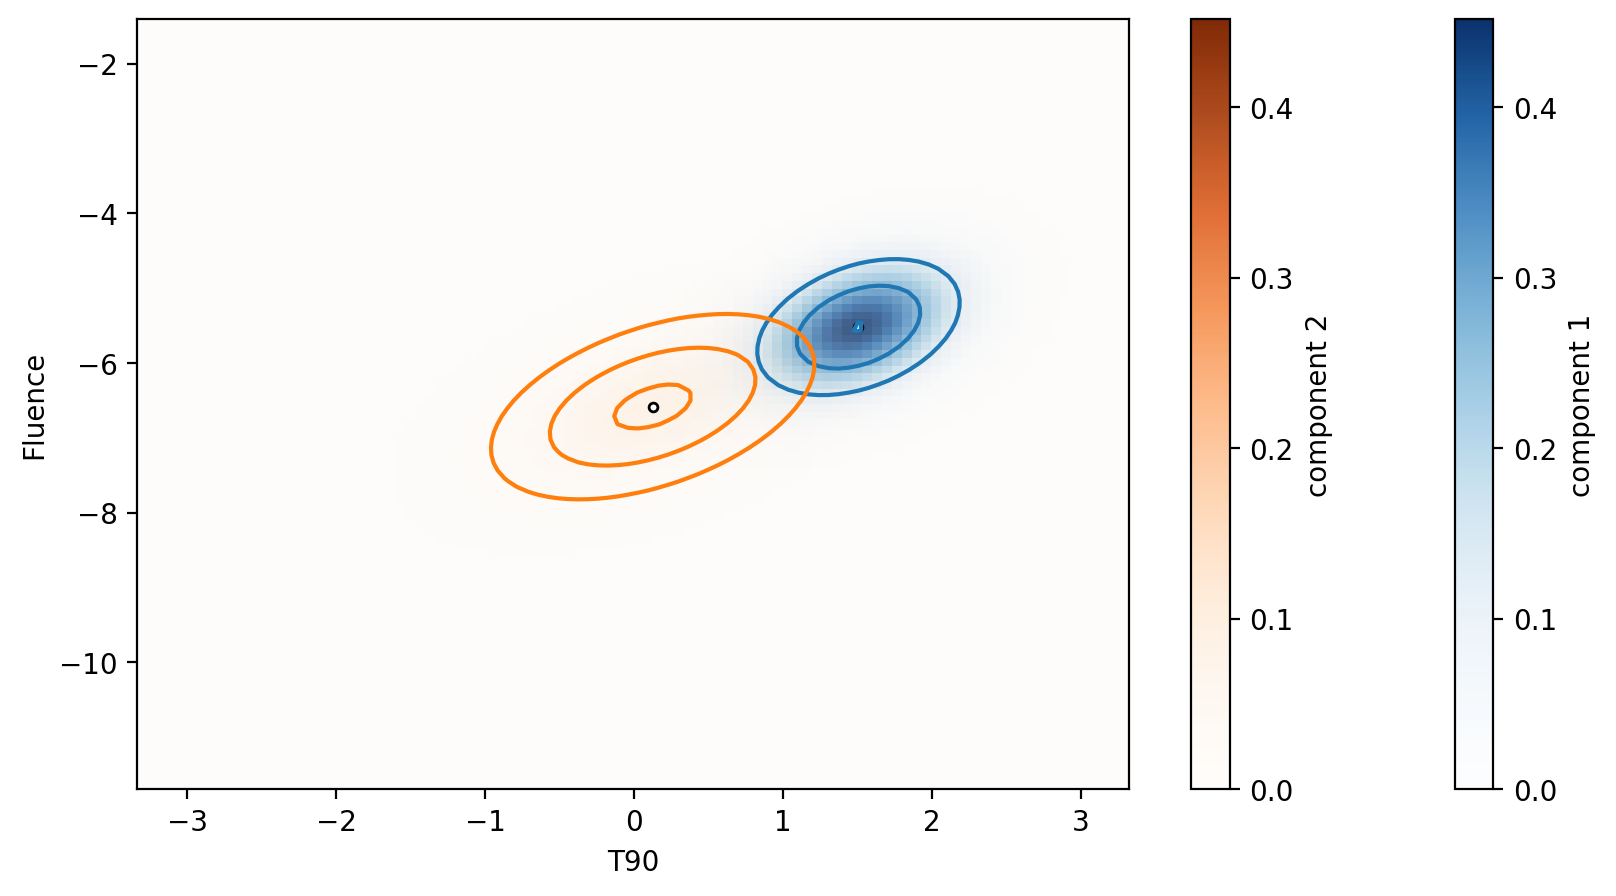

In [13]:
best_gmm = GaussianMixture(2, random_state=1).fit(T_f)
Tmin, Tmax = T_f[:, 0].min(), T_f[:, 0].max()
fmin, fmax = T_f[:, 1].min(), T_f[:, 1].max()
xx,yy = np.meshgrid(np.linspace(Tmin, Tmax, 100),
                     np.linspace(fmin, fmax, 100))
Xgrid = np.stack((xx,yy),axis=2).reshape(100 * 100,2)

logprob = best_gmm.score_samples(Xgrid)
pdf = np.exp(logprob)
densities = best_gmm.predict_proba(Xgrid)
sing_pdf = densities*pdf.reshape(-1,1)
means=best_gmm.means_
if means[0,0]<means[1,0]:
    means = means[::-1]
    sing_pdf = sing_pdf[:,::-1]
print('Gaussian Mixture : \n')
print('Means : \n', means)

cmap1 = plt.get_cmap('Blues')
cmap2 = plt.get_cmap('Oranges')

cmap1._init()
cmap2._init()
alphas = np.linspace(0.2, 1, cmap1.N+3)
cmap1._lut[:,-1] = alphas
cmap2._lut[:,-1] = alphas

plt.figure(figsize=(10,5))
for i,c,cmap in zip(range(2),colors,[cmap1,cmap2]):
    
    plt.imshow(sing_pdf[:,i].reshape(100,100), origin='lower', aspect='auto',
               extent=[Tmin, Tmax,
                       fmin, fmax],
               cmap=cmap, vmin=0,vmax=np.max(sing_pdf))
    plt.colorbar(label='component %i'%(i+1))
    plt.contour(xx, yy, sing_pdf[:,i].reshape(100,100), levels=3, colors=c)
    
plt.scatter(means[:,0],means[:,1], s=10, c='w', edgecolors='k')
plt.xlabel('T90')
plt.ylabel('Fluence')
plt.show()

The means of the two gaussians are extremely similar to the centers of the clusters obtained with K-means, so the two methods applied to this set of data are consistent.
In conclusion I can tell that there are two populations of GRB, with mean value of T90 equal to 32 s (component 1 / long GRB) and 1.4 s (component 2 / short GRB).
The first one has also values of fluence one order of magnitude higher than the second one: the means are $10^{-5.5} {\rm erg/cm}^2$ for long GRB and $10^{-6.6} {\rm erg/cm}^2$.

## Time, Fluence and Sky Location
Now I add the postion in the sky of the GRBs and I check if the two components are isotropic.

In [14]:
ra = np.array(data[3],dtype=float)
dec = np.array(data[4],dtype=float)
ra = ra[mask]
dec = dec[mask]
Tf_ang = np.column_stack([T,f,ra[mask4],dec[mask4]])

ra = Tf_ang[:,2]
dec = Tf_ang[:,3]

In [15]:
logprob = best_gmm.score_samples(T_f)
pdf = np.exp(logprob)
densities = best_gmm.predict_proba(T_f)
means=best_gmm.means_
if means[0,0]<means[1,0]:
    densities = densities[:,::-1]
component = np.array(densities[:,0]<densities[:,1],dtype='int')

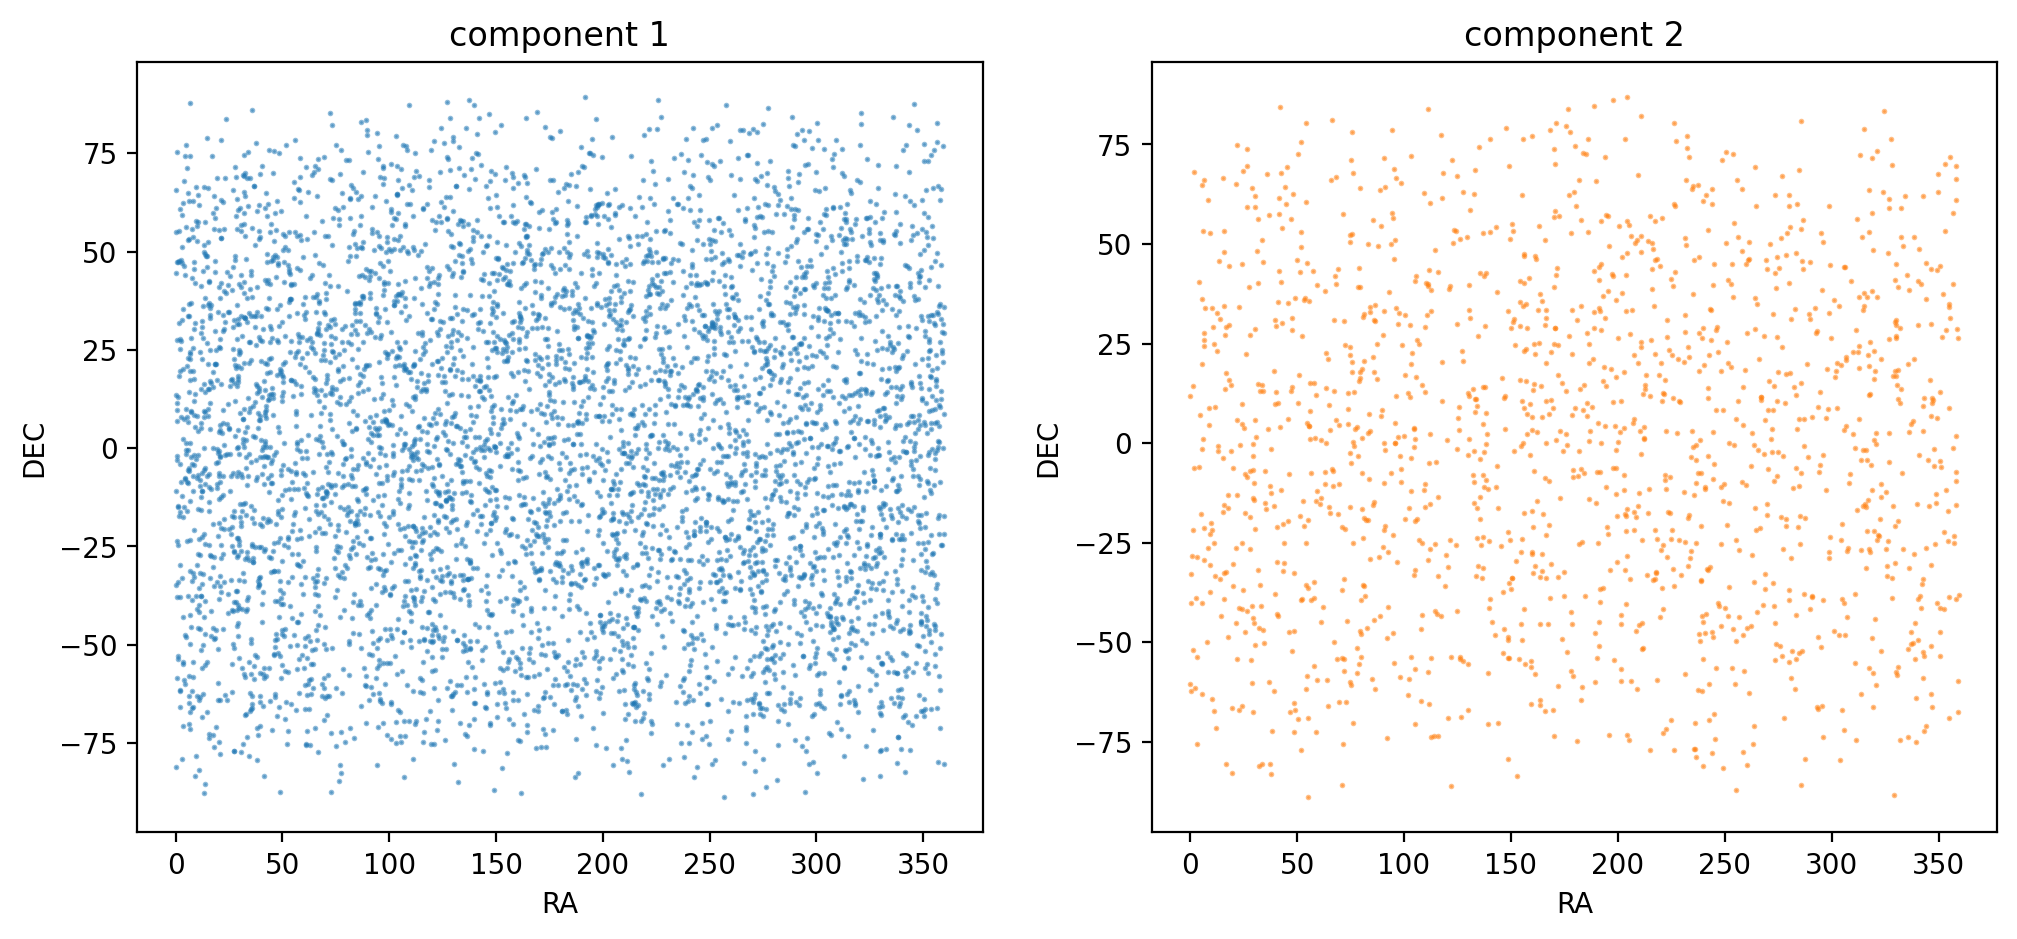

In [16]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12, 5))
for ax,i,c in zip([ax1,ax2], range(2), colors):
    ax.scatter(ra[component==i], dec[component==i],
            marker=".", s=4, alpha=0.5, c=c)
    ax.set_xlabel('RA')
    ax.set_ylabel('DEC')
    ax.set_title('component %i'%(i+1))


Their positions cover all the sky, so they are isotropic